In [76]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load the data

In [77]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [78]:
y.shape, tx.shape

((10000,), (10000, 2))

# Exercise 1

What does each column of X represent?
A: Each column of X represents a feature of the data.

What does each row of X represent?
A: Each row of X represents a sample of the data.

Why do we have 1's in the first column of X?
A: The 1's in the first column of X are used to represent the bias/offset term.

If we have heights and weights of 3 people, what would be the size of y and X?
A: y would be a 3x1 vector and X would be a 3x2 matrix. X_32 = weight of person 3.

### NB: throughout this laboratory the data has the following format: 
  * there are **N = 10000** data entries
  * **y** represents the column vector containing weight information -- that which we wish to predict/the output (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,)**.
  * **tx** represents the matrix $\tilde{X}$ formed by laterally concatenating a column vector of 1s to the column vector of height information -- the input data (see also the first page of $\texttt{exercise02.pdf}$). Its **shape** is **(N,2)**.

# 1. Computing the Cost Function
Fill in the `compute_loss` function below:

In [79]:
def compute_loss(y, tx, w):
    """Calculate the loss using either MSE.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2,). The vector of model parameters.

    Returns:
        the value of the loss (a scalar), corresponding to the input parameters w.
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: compute loss by MSE
    # ***************************************************
    sample_size = np.shape(y)[0]
    e = (y - tx @ w) ** 2
    return np.sum(e) / (2*sample_size)

# 2. Grid Search

Fill in the function `grid_search()` below:

In [80]:
# from costs import *


def grid_search(y, tx, grid_w0, grid_w1):
    """Algorithm for grid search.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        grid_w0: numpy array of shape=(num_grid_pts_w0, ). A 1D array containing num_grid_pts_w0 values of parameter w0 to be tested in the grid search.
        grid_w1: numpy array of shape=(num_grid_pts_w1, ). A 1D array containing num_grid_pts_w1 values of parameter w1 to be tested in the grid search.

    Returns:
        losses: numpy array of shape=(num_grid_pts_w0, num_grid_pts_w1). A 2D array containing the loss value for each combination of w0 and w1
    """

    losses = np.zeros((len(grid_w0), len(grid_w1)))
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: compute loss for each combination of w0 and w1.
    # ***************************************************
    for w_0_index, w_0 in enumerate(grid_w0):
        for w_1_index, w_1 in enumerate(grid_w1):
            w = np.array([w_0, w_1])
            losses[w_0_index, w_1_index] = compute_loss(y, tx, w)
    return losses

Let us play with the grid search demo now!

Grid Search: loss*=15.397905708213646, w0*=73.14629258517036, w1*=13.527054108216447, execution time=5.764 seconds


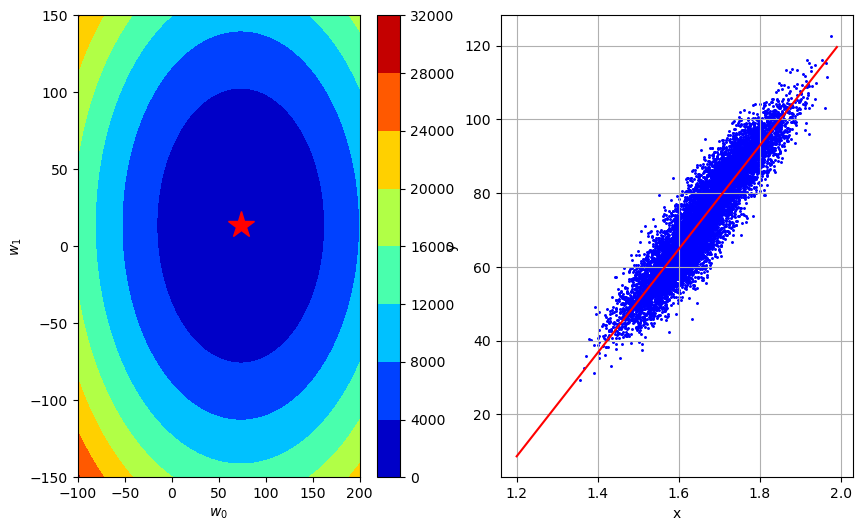

In [81]:
from grid_search import generate_w, get_best_parameters
from plots import grid_visualization

# Generate the grid of parameters to be swept
grid_w0, grid_w1 = generate_w(num_intervals=500)

# Start the grid search
start_time = datetime.datetime.now()
grid_losses = grid_search(y, tx, grid_w0, grid_w1)

# Select the best combinaison
loss_star, w0_star, w1_star = get_best_parameters(grid_w0, grid_w1, grid_losses)
end_time = datetime.datetime.now()
execution_time = (end_time - start_time).total_seconds()

# Print the results
print(
    "Grid Search: loss*={l}, w0*={w0}, w1*={w1}, execution time={t:.3f} seconds".format(
        l=loss_star, w0=w0_star, w1=w1_star, t=execution_time
    )
)

# Plot the results
fig = grid_visualization(grid_losses, grid_w0, grid_w1, mean_x, std_x, height, weight)
fig.set_size_inches(10.0, 6.0)
# fig.savefig("grid_plot")  # Optional saving

Does this look like a good estimate?
A: Not the best, the slope is slightly off. The MSE plot is not smooth because the grid is not fine enough.

Using a grid spacing of 50 instead of 10, we get a better fit. The computational cost also increases by N^2.

# 3. Gradient Descent

Again, please fill in the functions `compute_gradient` below:

In [82]:
def compute_gradient(y, tx, w):
    """Computes the gradient at w.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        An numpy array of shape (2, ) (same shape as w), containing the gradient of the loss at w.
    """
    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: compute gradient vector
    # ***************************************************
    sample_size = np.shape(y)[0]
    grad = (- 1 / sample_size) * tx.T @ (y - tx @ w)
    return grad

In [83]:
print(compute_gradient(y, tx, np.array([200, 20])))
print(compute_gradient(y, tx, np.array([50, 10])))

[126.706078     6.52028757]
[-23.293922    -3.47971243]


The gradient of w=[100, 20] is larger, telling us the slope is steeper and we need to take larger steps.

Please fill in the functions `gradient_descent` below:

In [84]:
def gradient_descent(y, tx, initial_w, max_iters, gamma):
    """The Gradient Descent (GD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of GD
        ws: a list of length max_iters + 1 containing the model parameters as numpy arrays of shape (2, ),
            for each iteration of GD (as well as the final weights)
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: compute gradient and loss
        # ***************************************************
        gradient = compute_gradient(y, tx, w)
        loss = compute_loss(y, tx, w)
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: update w by gradient
        # ***************************************************
        w = w - gamma * gradient

        # store w and loss
        ws.append(w)
        losses.append(loss)
        print(
            "GD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )

    return losses, ws

Test your gradient descent function through gradient descent demo shown below:

In [85]:
# from gradient_descent import *
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()
gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=2792.2367127591674, w0=51.30574540147358, w1=9.435798704492154
GD iter. 1/49: loss=265.30246210896166, w0=66.69746902191571, w1=12.266538315839956
GD iter. 2/49: loss=37.878379550441316, w0=71.31498610804832, w1=13.115760199244315
GD iter. 3/49: loss=17.41021212017453, w0=72.70024123388812, w1=13.370526764265625
GD iter. 4/49: loss=15.568077051450466, w0=73.11581777164007, w1=13.446956733772021
GD iter. 5/49: loss=15.402284895265295, w0=73.24049073296565, w1=13.469885724623941
GD iter. 6/49: loss=15.38736360120863, w0=73.27789262136334, w1=13.476764421879516
GD iter. 7/49: loss=15.38602068474353, w0=73.28911318788263, w1=13.478828031056189
GD iter. 8/49: loss=15.385899822261674, w0=73.29247935783842, w1=13.47944711380919
GD iter. 9/49: loss=15.385888944638305, w0=73.29348920882515, w1=13.47963283863509
GD iter. 10/49: loss=15.3858879656522, w0=73.29379216412117, w1=13.479688556082861
GD iter. 11/49: loss=15.385887877543452, w0=73.29388305070998, w1=13.47970527131719

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

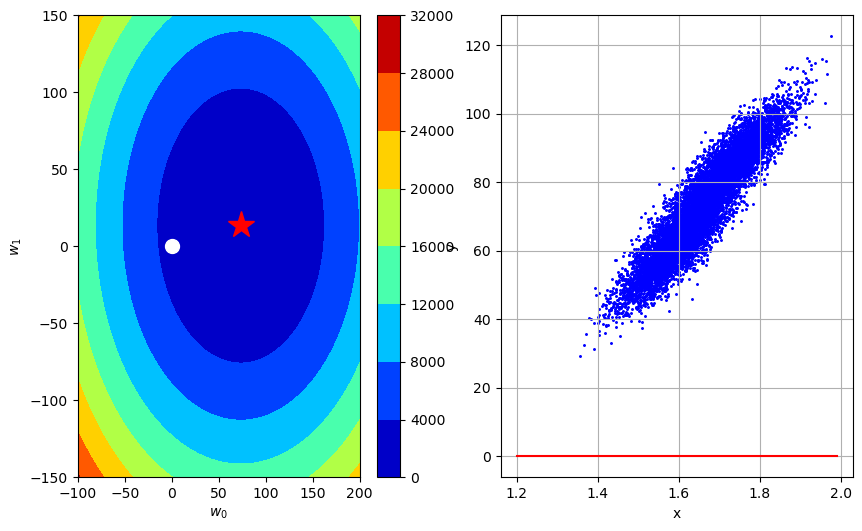

In [86]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

# 4. Stochastic gradient descent

In [87]:
def compute_stoch_gradient(y, tx, w):
    """Compute a stochastic gradient at w from a data sample batch of size B, where B < N, and their corresponding labels.

    Args:
        y: numpy array of shape=(B, )
        tx: numpy array of shape=(B,2)
        w: numpy array of shape=(2, ). The vector of model parameters.

    Returns:
        A numpy array of shape (2, ) (same shape as w), containing the stochastic gradient of the loss at w.
    """

    # ***************************************************
    # INSERT YOUR CODE HERE
    # TODO: implement stochastic gradient computation. It's the same as the usual gradient.
    # ***************************************************
    sample_size = np.shape(y)[0]
    grad = (-1 / sample_size) * tx.T @ (y - tx @ w)
    return grad


def stochastic_gradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """The Stochastic Gradient Descent algorithm (SGD).

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic gradient
        max_iters: a scalar denoting the total number of iterations of SGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    n_iter = 0

    for batch_y, batch_tx in batch_iter(y, tx, batch_size, max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: implement stochastic gradient descent.
        # ***************************************************
        gradient = compute_stoch_gradient(batch_y, batch_tx, w)
        loss = compute_loss(y, tx, w)
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: update w by gradient
        # ***************************************************
        w = w - gamma * gradient

        # store w and loss
        ws.append(w)
        losses.append(loss)

        print(
            "SGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )
        n_iter += 1
        
    return losses, ws

In [88]:
# from stochastic_gradient_descent import *

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.1
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SGD.
start_time = datetime.datetime.now()
sgd_losses, sgd_ws = stochastic_gradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD iter. 0/49: loss=2792.2367127591674, w0=7.838502399037495, w1=5.1461438603784435
SGD iter. 1/49: loss=2192.3160481695268, w0=14.045620525981967, w1=-1.055706024745768
SGD iter. 2/49: loss=1876.205696671421, w0=18.008136547765012, w1=-5.236489578045984
SGD iter. 3/49: loss=1718.7930334168625, w0=23.886452747435346, w1=-3.5664338279666272
SGD iter. 4/49: loss=1381.2204481534402, w0=27.505993821073893, w1=-5.643860637406366
SGD iter. 5/49: loss=1246.5085949520917, w0=31.265824181846938, w1=-5.763615198365104
SGD iter. 6/49: loss=1083.7192202657325, w0=34.81618980900479, w1=-5.529108425731969
SGD iter. 7/49: loss=936.3214604882972, w0=36.88920550561143, w1=-7.277952149188932
SGD iter. 8/49: loss=893.4778989584895, w0=42.64972207590817, w1=-3.5066074047433617
SGD iter. 9/49: loss=629.1869132760388, w0=43.4223767648047, w1=-4.322544837980587
SGD iter. 10/49: loss=620.0006773073736, w0=44.0117108067964, w1=-4.955625651113853
SGD iter. 11/49: loss=614.0406792866206, w0=44.829054898695304, 

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

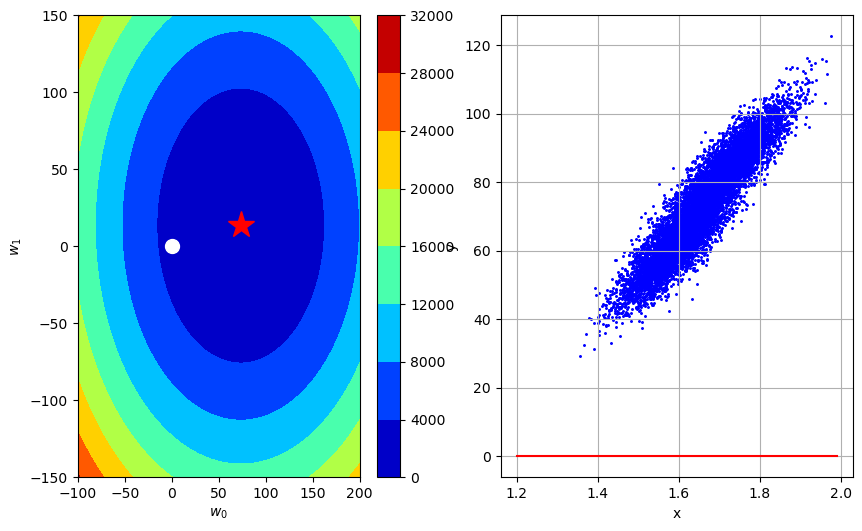

In [89]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_losses,
        sgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_ws)))

Difference: Initially, the stochastic gradient descent is more noisy, but eventually it still converges with a negligible higher error.

SGD took less time (0.003s) than GD (0.005s)

# 5. Effect of Outliers and MAE Cost Function

In [90]:
import datetime
from helpers import *

# ***************************************************
# INSERT YOUR CODE HERE
# TODO: reload the data by subsampling first, then by subsampling and adding outliers
# ***************************************************
height, weight, gender = load_data(sub_sample=True, add_outlier=True)

x, mean_x, std_x = standardize(height)
y, tx = build_model_data(x, weight)

In [91]:
y.shape, tx.shape

((202,), (202, 2))

In [92]:
from plots import gradient_descent_visualization

# Define the parameters of the algorithm.
max_iters = 50
gamma = 0.7

# Initialization
w_initial = np.array([0, 0])

# Start gradient descent.
start_time = datetime.datetime.now()

# ***************************************************
# INSERT YOUR CODE HERE
# TODO: fit the model to the subsampled data / subsampled data with outliers and visualize the cloud of points
#       and the model fit
# ***************************************************
gd_losses, gd_ws = gradient_descent(y, tx, w_initial, max_iters, gamma)


end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("GD: execution time={t:.3f} seconds".format(t=exection_time))

GD iter. 0/49: loss=2869.8351145358524, w0=51.847464098448434, w1=7.724426406192428
GD iter. 1/49: loss=318.2821247015961, w0=67.40170332798299, w1=10.041754328050118
GD iter. 2/49: loss=88.6423556165127, w0=72.06797509684336, w1=10.736952704607411
GD iter. 3/49: loss=67.9747763988552, w0=73.46785662750146, w1=10.945512217574596
GD iter. 4/49: loss=66.11469426926604, w0=73.88782108669889, w1=11.00808007146475
GD iter. 5/49: loss=65.94728687760302, w0=74.01381042445813, w1=11.026850427631796
GD iter. 6/49: loss=65.93222021235334, w0=74.0516072257859, w1=11.03248153448191
GD iter. 7/49: loss=65.93086421248088, w0=74.06294626618423, w1=11.034170866536943
GD iter. 8/49: loss=65.93074217249236, w0=74.06634797830372, w1=11.034677666153454
GD iter. 9/49: loss=65.93073118889338, w0=74.06736849193958, w1=11.034829706038407
GD iter. 10/49: loss=65.93073020036948, w0=74.06767464603033, w1=11.034875318003893
GD iter. 11/49: loss=65.93073011140233, w0=74.06776649225755, w1=11.03488900159354
GD iter

interactive(children=(IntSlider(value=1, description='n_iter', max=51, min=1), Output()), _dom_classes=('widge…

<function __main__.plot_figure(n_iter)>

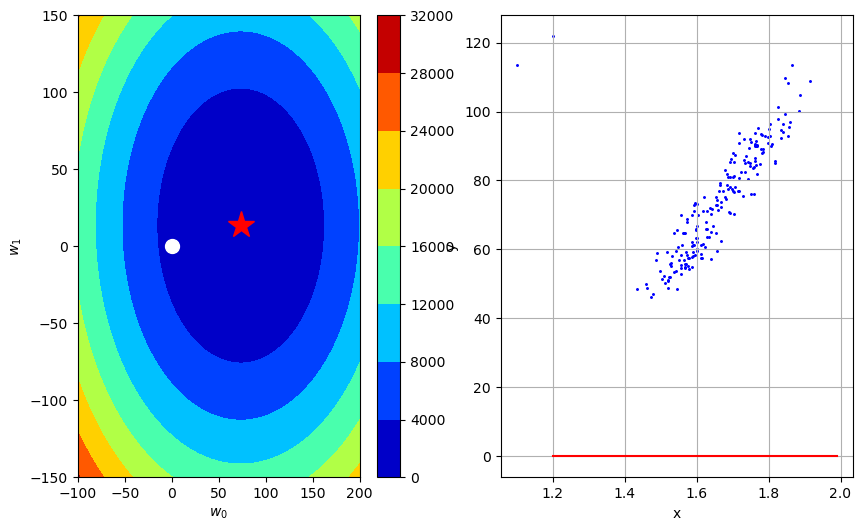

In [93]:
# Time Visualization
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        gd_losses,
        gd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(gd_ws)))

The fit is worst with outliers for MSE.

# 6. Subgradient descent

In [94]:
def compute_loss_mae(y, tx, w):
    """Calculate the loss using MAE.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        w: numpy array of shape=(2,). The vector of model parameters.

    Returns:
        the value of the loss (a scalar), corresponding to the input parameters w.
    """
    sample_size = np.shape(y)[0]
    e = np.absolute(y - tx @ w)
    return np.sum(e) / (sample_size)


def compute_subgradient_mae(y, tx, w):

    """Compute a subgradient of the MAE at w.


    Args:

        y: numpy array of shape=(N, )

        tx: numpy array of shape=(N,2)

        w: numpy array of shape=(2, ). The vector of model parameters.


    Returns:

        A numpy array of shape (2, ) (same shape as w), containing the subgradient of the MAE at w.

    """
    N = np.shape(y)[0]
    grad = np.zeros(2)
    e = y - tx @ w
    grad[0] = -np.sum(np.sign(e)) / N
    grad[1] = -np.sign(e) @ tx[:, 1] / N
    
    return grad

In [95]:
def subgradient_descent(y, tx, initial_w, max_iters, gamma):
    """The SubGradient Descent (SubGD) algorithm.

    Args:
        y: numpy array of shape=(N, )
        tx: numpy array of shape=(N,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        max_iters: a scalar denoting the total number of iterations of GD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubGD
    """
    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    for n_iter in range(max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: compute subgradient and loss
        # ***************************************************
        subgradient = compute_subgradient_mae(y, tx, w)
        loss = compute_loss_mae(y, tx, w)
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: update w by subgradient
        # ***************************************************
        w = w - gamma * subgradient

        ws.append(w)
        losses.append(loss)
        print(
            "SubGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )

    return losses, ws

In [96]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subgd_losses, subgd_ws = subgradient_descent(y, tx, w_initial, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubGD: execution time={t:.3f} seconds".format(t=exection_time))

SubGD iter. 0/499: loss=74.06780585492638, w0=0.7, w1=7.325273501091131e-16
SubGD iter. 1/499: loss=73.36780585492637, w0=1.4, w1=1.4650547002182263e-15
SubGD iter. 2/499: loss=72.66780585492637, w0=2.0999999999999996, w1=2.1975820503273395e-15
SubGD iter. 3/499: loss=71.96780585492638, w0=2.8, w1=2.9301094004364526e-15
SubGD iter. 4/499: loss=71.26780585492638, w0=3.5, w1=3.662636750545566e-15
SubGD iter. 5/499: loss=70.56780585492638, w0=4.2, w1=4.395164100654679e-15
SubGD iter. 6/499: loss=69.86780585492637, w0=4.9, w1=5.1276914507637925e-15
SubGD iter. 7/499: loss=69.16780585492639, w0=5.6000000000000005, w1=5.860218800872906e-15
SubGD iter. 8/499: loss=68.46780585492637, w0=6.300000000000001, w1=6.5927461509820194e-15
SubGD iter. 9/499: loss=67.76780585492638, w0=7.000000000000001, w1=7.325273501091133e-15
SubGD iter. 10/499: loss=67.06780585492638, w0=7.700000000000001, w1=8.057800851200246e-15
SubGD iter. 11/499: loss=66.36780585492637, w0=8.4, w1=8.79032820130936e-15
SubGD iter

interactive(children=(IntSlider(value=1, description='n_iter', max=501, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>

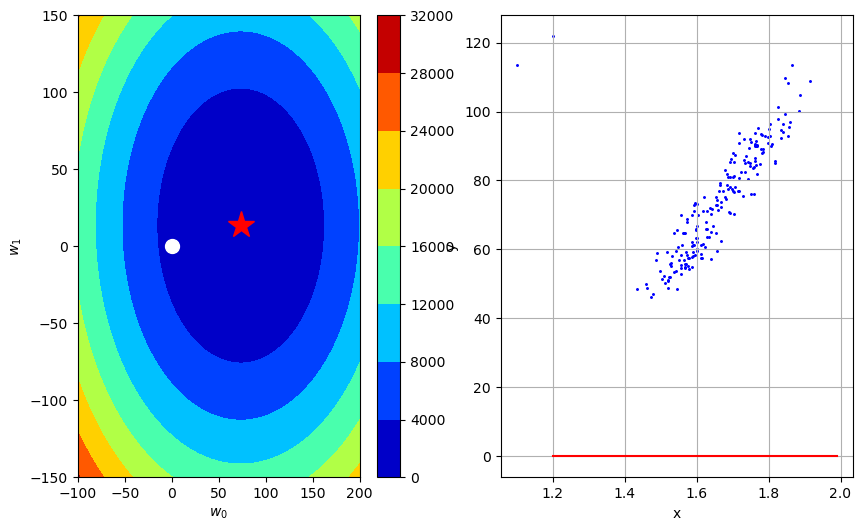

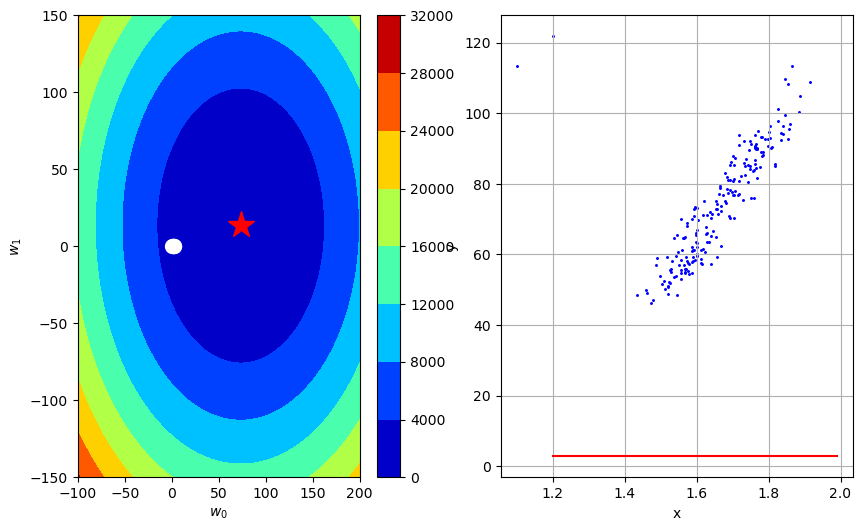

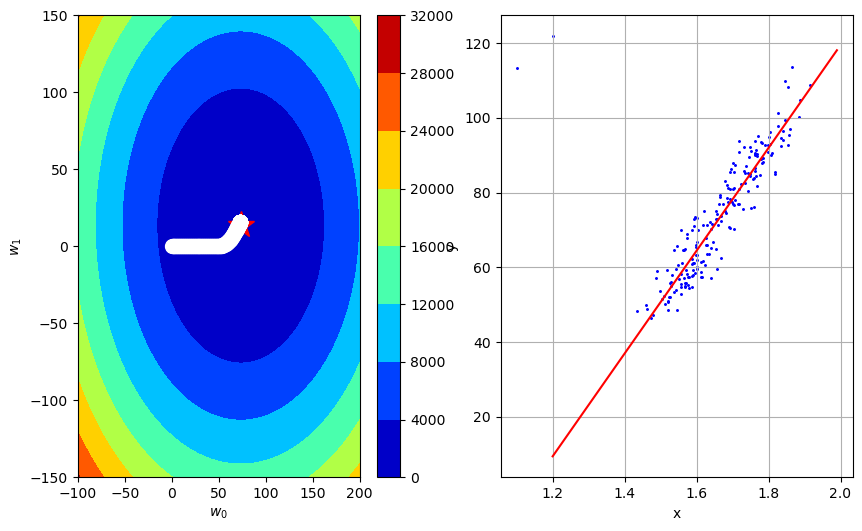

In [97]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subgd_losses,
        subgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subgd_ws)))

# Stochastic Subgradient Descent

**NB** for the computation of the subgradient you can reuse the `compute_subgradient` method that you implemented above, just making sure that you pass in a minibatch as opposed to the full data.

In [104]:
def stochastic_subgradient_descent(y, tx, initial_w, batch_size, max_iters, gamma):
    """Compute a stochastic subgradient at w from a data sample batch of size B, where B < N, and their corresponding labels.

    Args:
        y: numpy array of shape=(B, )
        tx: numpy array of shape=(B,2)
        initial_w: numpy array of shape=(2, ). The initial guess (or the initialization) for the model parameters
        batch_size: a scalar denoting the number of data points in a mini-batch used for computing the stochastic subgradient
        max_iters: a scalar denoting the total number of iterations of SubSGD
        gamma: a scalar denoting the stepsize

    Returns:
        losses: a list of length max_iters containing the loss value (scalar) for each iteration of SubSGD
        ws: a list of length max_iters containing the model parameters as numpy arrays of shape (2, ), for each iteration of SubSGD
    """

    # Define parameters to store w and loss
    ws = [initial_w]
    losses = []
    w = initial_w
    n_iter = 0

    for batch_y, batch_tx in batch_iter(y, tx, batch_size, max_iters):
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: implement stochastic gradient descent.
        # ***************************************************
        gradient = compute_subgradient_mae(batch_y, batch_tx, w)
        loss = compute_loss_mae(y, tx, w)
        # ***************************************************
        # INSERT YOUR CODE HERE
        # TODO: update w by gradient
        # ***************************************************
        w = w - gamma * gradient

        losses.append(loss)
        ws.append(w)
        
        print(
            "SubSGD iter. {bi}/{ti}: loss={l}, w0={w0}, w1={w1}".format(
                bi=n_iter, ti=max_iters - 1, l=loss, w0=w[0], w1=w[1]
            )
        )
        n_iter += 1
    return losses, ws

In [105]:
# Define the parameters of the algorithm.
max_iters = 500
gamma = 0.7
batch_size = 1

# Initialization
w_initial = np.array([0, 0])

# Start SubSGD.
start_time = datetime.datetime.now()
subsgd_losses, subsgd_ws = stochastic_subgradient_descent(
    y, tx, w_initial, batch_size, max_iters, gamma
)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SubSGD: execution time={t:.3f} seconds".format(t=exection_time))

SubSGD iter. 0/499: loss=74.06780585492638, w0=0.7, w1=0.14333059059451644
SubSGD iter. 1/499: loss=73.36780585492637, w0=1.4, w1=0.23185810408364232
SubSGD iter. 2/499: loss=72.66780585492639, w0=2.0999999999999996, w1=0.46097979637040043
SubSGD iter. 3/499: loss=71.96780585492638, w0=2.8, w1=-0.10898032816558545
SubSGD iter. 4/499: loss=71.2678058549264, w0=3.5, w1=-0.7300319017361789
SubSGD iter. 5/499: loss=70.56780585492638, w0=4.2, w1=-1.2197154351327673
SubSGD iter. 6/499: loss=69.86780585492637, w0=4.9, w1=-2.061133944858712
SubSGD iter. 7/499: loss=69.16780585492639, w0=5.6000000000000005, w1=-2.901161516318523
SubSGD iter. 8/499: loss=68.46780585492638, w0=6.300000000000001, w1=-6.2743051939082
SubSGD iter. 9/499: loss=67.76780585492638, w0=7.000000000000001, w1=-6.355119499396911
SubSGD iter. 10/499: loss=67.06780585492638, w0=7.700000000000001, w1=-6.778358924169425
SubSGD iter. 11/499: loss=66.36780585492639, w0=8.4, w1=-6.741071612551556
SubSGD iter. 12/499: loss=65.66780

interactive(children=(IntSlider(value=1, description='n_iter', max=501, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>

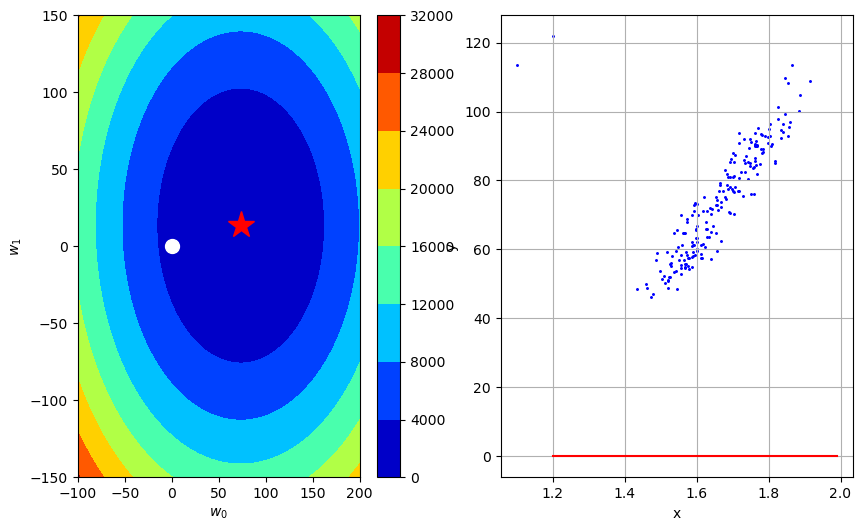

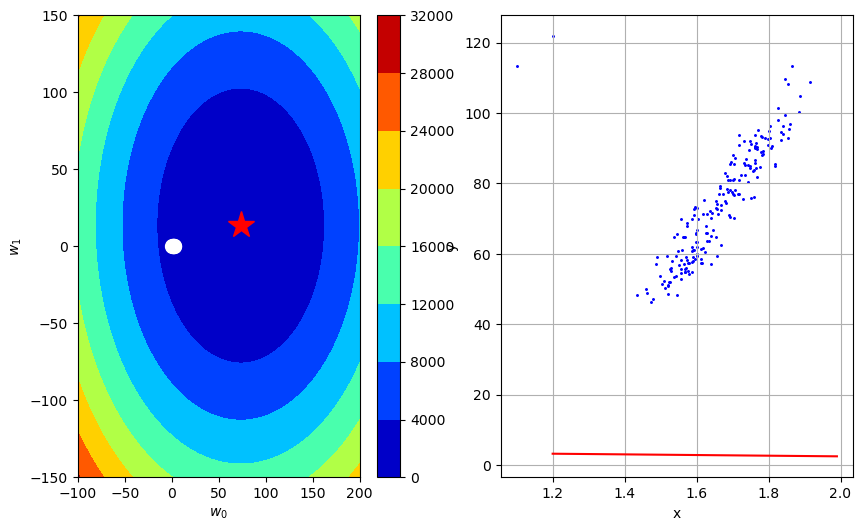

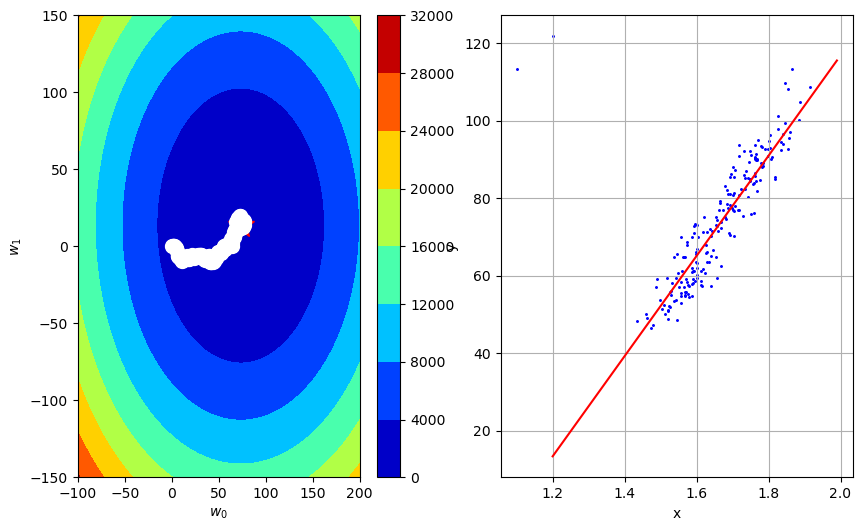

In [106]:
from ipywidgets import IntSlider, interact


def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        subsgd_losses,
        subsgd_ws,
        grid_losses,
        grid_w0,
        grid_w1,
        mean_x,
        std_x,
        height,
        weight,
        n_iter,
    )
    fig.set_size_inches(10.0, 6.0)


interact(plot_figure, n_iter=IntSlider(min=1, max=len(subsgd_ws)))

For MAE,

With SGD, the iterations are noisier, and actually took longer to converge than GD.